In [181]:
import pandas as pd
import geopy.distance

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np


### Sedes y escuelas

In [182]:
def clip_lat_lng(df, coords):
    """
    coords: ((lng_o, lng_e) ,(lat_s, lat_n))
    """
    ((O, E), (S, N)) = coords
    
    df_clip = df.loc[(df['lng'] > O) & (df['lng'] <= E) & (df['lat'] < N) & (df['lat'] >= S)]
    return df_clip

sedes_loc = pd.read_csv('sedes_loc_clean.csv') #Univs
escuelas = pd.read_csv('esc_med_BUE_CABA.csv') #Schools


In [183]:
# Distancia entre sedes

def f(x, col1 = 'coords_x', col2 = 'coords_y'):    
    return geopy.distance.vincenty(x[col1], x[col2]).km

import networkx as nx

def compute_zonas(df_loc, th = .3, prefix = None):
    """
    df_loc: Pandas DataFrame. Needs to have 'lat' and 'lng' columns.
    th: distance (in distance_mat's units) below which points are connected as part of a single 'zona'

    """
    df_loc['coords'] = list(zip(df_loc.lat, df_loc.lng))
    
    df_for_dist = df_loc['coords'].reset_index()
    df_for_dist['key'] = 0
    distances = pd.merge(df_for_dist, df_for_dist, on = 'key').drop('key', axis = 1)
    distances['distance_km'] = distances.apply(f, axis=1)
    
    distance_mat = distances.set_index(['index_x', 'index_y']).unstack()['distance_km']
    
    A = (distance_mat < .3).astype(int)
    G = nx.convert_matrix.from_pandas_adjacency(A)
    
    sedes_en_zona = [list(s) for s in sorted(nx.connected_components(G), key = len, reverse=True)]

    df_loc['zona_id'] = None
    for i in range(len(sedes_en_zona)):
        df_loc.loc[sedes_en_zona[i], 'zona_id'] = i

    zonas = df_loc.groupby('zona_id')['lat', 'lng'].mean().reset_index()

    if prefix != None:
        zf = zonas_s['zona_id'].astype(str).str.len().max()
        zonas['zona_id'] = prefix+zonas['zona_id'].astype(str).str.zfill(zf)
        df_loc['zona_id'] = prefix+df_loc['zona_id'].astype(str).str.zfill(zf)
    return df_loc, zonas


In [184]:
# Computar zonas para universidades y escuelas

df_loc_u, zonas_u = compute_zonas(sedes_loc[['lat', 'lng']].drop_duplicates(), th = .5, prefix = 'U')


In [185]:

df_loc_s, zonas_s = compute_zonas(escuelas[['lat', 'lng']].drop_duplicates(), th = .3, prefix = 'S')


In [186]:
# save. Zonas are index for the zones and df_loc let us match to the buildings by their coordinates.

zonas_u.to_csv('zonas_u.csv', index = False)
zonas_s.to_csv('zonas_s.csv', index = False)

sedes_loc.merge(df_loc_u, how = 'left').to_csv('./sedes_loc_clean_z.csv', index = False)
escuelas.merge(df_loc_s, how = 'left').to_csv('escuelas_z.csv', index = False)


### Poligonos AMBA

In [187]:
# Cargar localidades
import geopandas as gpd

localidades = gpd.read_file('./localidades/localidades.geojson').rename({'NOM_ENTI': 'Localidad'},axis = 1)
barrios = gpd.read_file('./localidades/barrios_badata.shp').to_crs({'init': 'epsg:4326'}).rename({'WKT': 'geometry', 'BARRIO': 'Localidad'},axis = 1)

localidades = pd.concat([localidades, barrios]).dropna(axis = 1).reset_index().rename({'index': 'index_l'}, axis = 1)
localidades['Centroid'] = [(P.y, P.x) for P in localidades['geometry'].centroid]

partidos = gpd.read_file('./localidades/partidos.shp')['geometry'].to_crs({'init': 'epsg:4326'})

import shapely

ejido = gpd.read_file('./ejido.json')
AMBA_region = gpd.GeoSeries(shapely.geometry.Polygon([(-59.2,-35.1), (-57.8,-35.1), (-57.8,-34.05), (-59.2,-34.05)]))
rural_region = AMBA_region.difference(ejido['geometry'])

/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



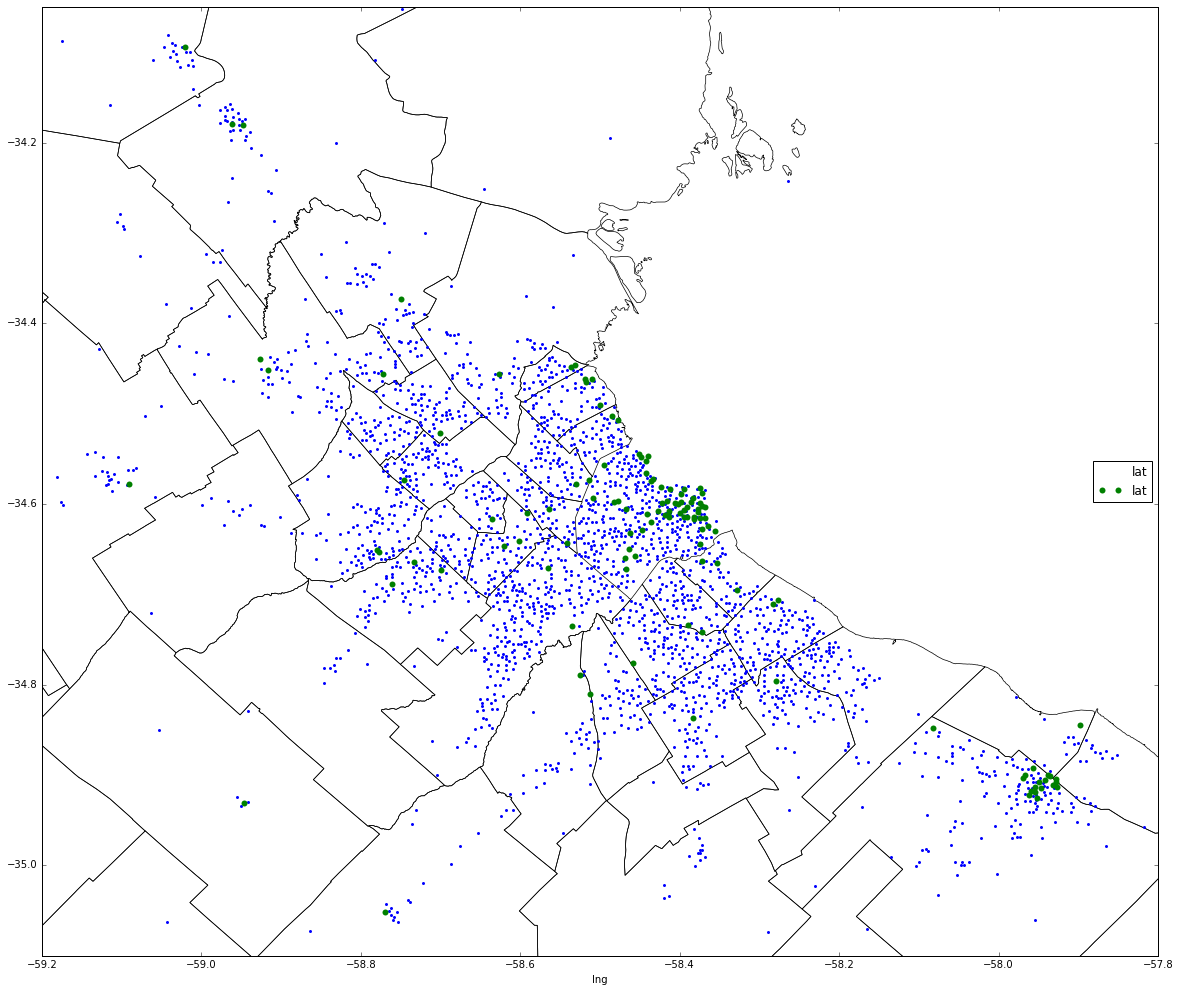

In [188]:

fig, ax = plt.subplots(1, figsize = (20, 17))

zonas_s.plot(x = 'lng', y = 'lat', marker = '.', ax = ax, linewidth = 0, mec = 'None')
zonas_u.plot(x = 'lng', y = 'lat', marker = 'o', ax = ax, linewidth = 0, mec = 'None')

rural_region.plot(ax = ax, color = 'w', linewidth = 0)
partidos.plot(ax = ax, facecolor="none", edgecolor='black', lw=0.7)
# ax.set_title(temas)
ax.set_xlim(-59.2, -57.8)
ax.set_ylim(-35.1, -34.05)

plt.show()

### Zones to Mapbox

In [156]:
sedes_loc.merge(df_loc_u).nunique()


Domicilio      645
Facultad       715
Municipio      151
Pais             1
Provincia       24
Universidad    125
index          645
lat            564
lng            564
coords         565
zona_id        477
dtype: int64

In [154]:
zonas_u

,zona_id,lat,lng
0,U000,-34.601911,-58.392028
1,U001,-34.597670,-58.398865
2,U002,-32.483096,-58.231483
3,U003,-24.184640,-65.303033
4,U004,-34.565452,-58.442753
5,U005,-31.438018,-64.187643
6,U006,-31.418691,-64.187038
7,U007,-34.615085,-58.366062
8,U008,-34.575187,-58.436787
9,U009,-34.609123,-58.377603


In [180]:
import geojson

def df_sc2geojson(df, filename):
    features = []
    insert_features = lambda X: features.append(
            geojson.Feature(geometry=geojson.Point((X['lng'],
                                                    X['lat'])),
                            properties=dict(nombre=X['nombre_estab'], Matricula_est_5to=X['Matricula est 5to'], zona_escolar=X['zona_id'])))
    df.apply(insert_features, axis=1)
    with open(filename+'.geojson', 'w') as fp:
        geojson.dump(geojson.FeatureCollection(features), fp, sort_keys=True, ensure_ascii=False)

def df_sc_z2geojson(df, filename):
    features = []
    insert_features = lambda X: features.append(
            geojson.Feature(geometry=geojson.Point((X['lng'],
                                                    X['lat'])),
                            properties=dict(zona_id=X['zona_id'])))
    df.apply(insert_features, axis=1)
    with open(filename+'.geojson', 'w') as fp:
        geojson.dump(geojson.FeatureCollection(features), fp, sort_keys=True, ensure_ascii=False)

def df_uni2geojson(df, filename):
    features = []
    insert_features = lambda X: features.append(
            geojson.Feature(geometry=geojson.Point((X['lng'],
                                                    X['lat'])),
                            properties=dict(Facultad=X['Facultad'], Universidad = X['Universidad'], Direccion = X['Domicilio'])))
    df.apply(insert_features, axis=1)
    with open(filename+'.geojson', 'w') as fp:
        geojson.dump(geojson.FeatureCollection(features), fp, sort_keys=True, ensure_ascii=False)

def df_uni_z2geojson(df, filename):
    features = []
    insert_features = lambda X: features.append(
            geojson.Feature(geometry=geojson.Point((X['lng'],
                                                    X['lat'])),
                            properties=dict(zona_id=X['zona_id'])))
    df.apply(insert_features, axis=1)
    with open(filename+'.geojson', 'w') as fp:
        geojson.dump(geojson.FeatureCollection(features), fp, sort_keys=True, ensure_ascii=False)


df_sc2geojson(escuelas.merge(df_loc_s).dropna(), 'escuelas')
df_sc_z2geojson(zonas_s, 'escuelas_z')
df_uni2geojson(sedes_loc.merge(df_loc_u), 'univs')
df_uni_z2geojson(zonas_u, 'univs_z')

# coordinates = []
# for line in paths_info[('path', 'Line')]:
#     try:
#         coordinates += [[[line.xy[0][i], line.xy[1][i]] for i in range(len(line.xy[0]))]]
#     except AttributeError:
#         coordinates += [np.nan]
        
from mapbox import Uploader
import json

username = 'matuteiglesias'
token = 'sk.eyJ1IjoibWF0dXRlaWdsZXNpYXMiLCJhIjoiY2puODA4bW8xMGV1dzNrcGtiOGp6NXQ5aCJ9.DohKmjn_o6MK1Y4Q5FG8ew'

service = Uploader(access_token=token)
with open('escuelas.geojson', 'r') as src:
    upload_resp = service.upload(src, username+'.escuelas')
    
with open('escuelas_z.geojson', 'r') as src:
    upload_resp = service.upload(src, username+'.escuelas_z')
    
with open('univs.geojson', 'r') as src:
    upload_resp = service.upload(src, username+'.univs')
    
with open('univs_z.geojson', 'r') as src:
    upload_resp = service.upload(src, username+'.univs_z')
    

In [4]:
escuelas = pd.read_csv('esc_med_BUE_CABA.csv')
escuelas = escuelas.groupby(['cue', 'nombre_estab', 'lat', 'lng', 'municipio', 'Provincia', 'sector de gestión'])['Matricula est 5to'].sum().reset_index()

# mask_lng = (escuelas['lng'] > -58.55) & (escuelas['lng'] <= -58.45)
# mask_lat = (escuelas['lat'] < -34.5) & (escuelas['lat'] >= -34.6)
mask_lng = (escuelas['lng'] > -59.2) & (escuelas['lng'] <= -57.8)
mask_lat = (escuelas['lat'] < -34.05) & (escuelas['lat'] >= -35.1)

escuelas_mask = escuelas.loc[mask_lng & mask_lat]
escuelas_mask['coords_o'] = list(zip(escuelas_mask.lat, escuelas_mask.lng))


/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [50]:
# Compute distance matrix (to places)

origenes = escuelas_mask[['coords_o']].reset_index()

destinos = localidades[['Localidad', 'Centroid']].drop_duplicates()

origenes['key'] = 0
destinos['key'] = 0
distances = pd.merge(origenes, destinos,on='key').set_index(['index', 'Localidad']).drop('key', axis = 1)

# distances
def f(x, orig_col = 'Centroid', dest_col = 'coords_o'):    
    return geopy.distance.vincenty(x[orig_col], x[dest_col]).km

distances['distance_km'] = distances.apply(f, axis=1)

dist_places = distances.reset_index().pivot_table(values='distance_km', index='index', columns = 'Localidad')

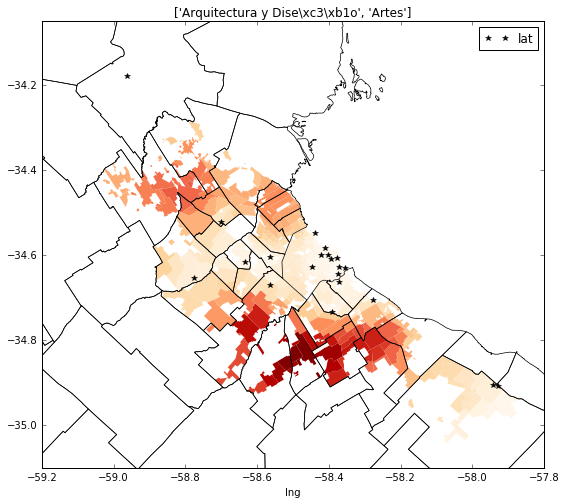

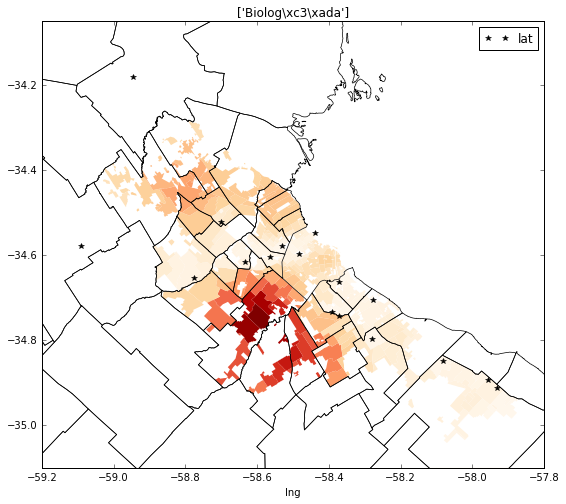

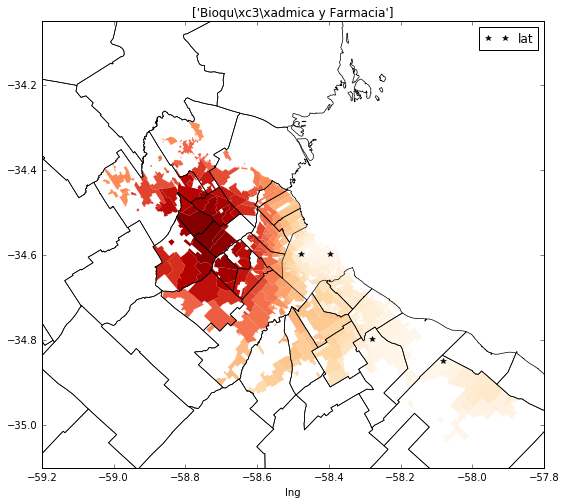

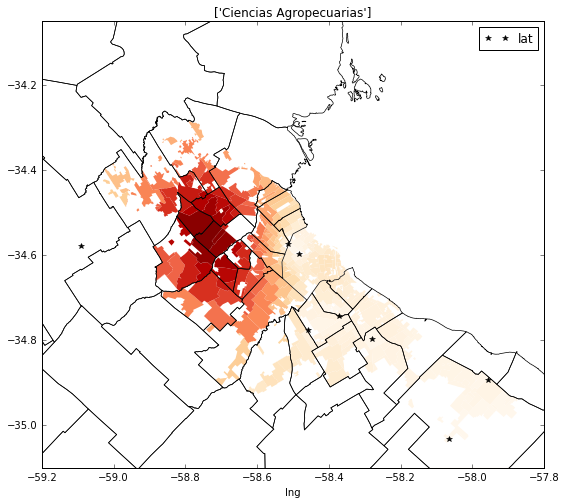

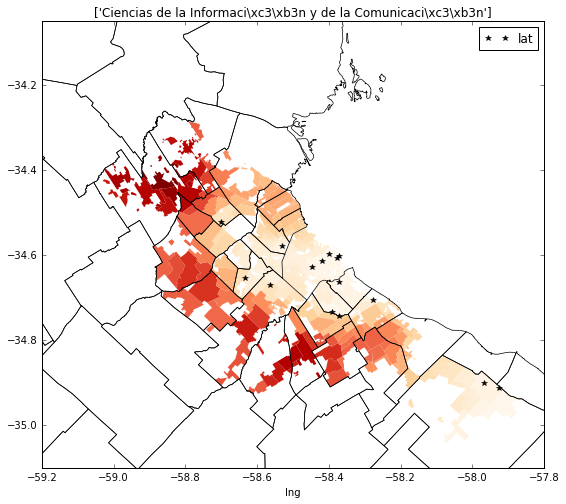

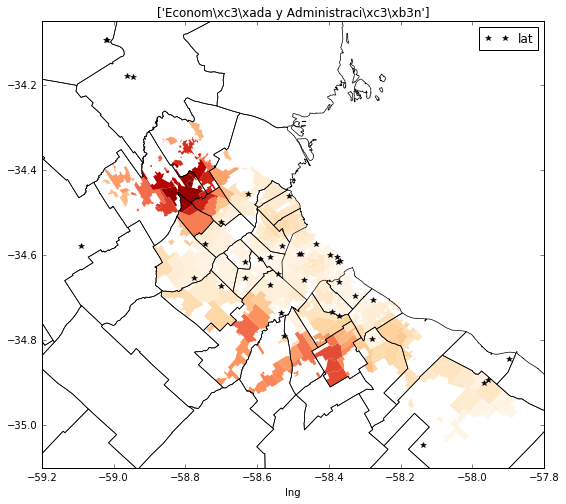

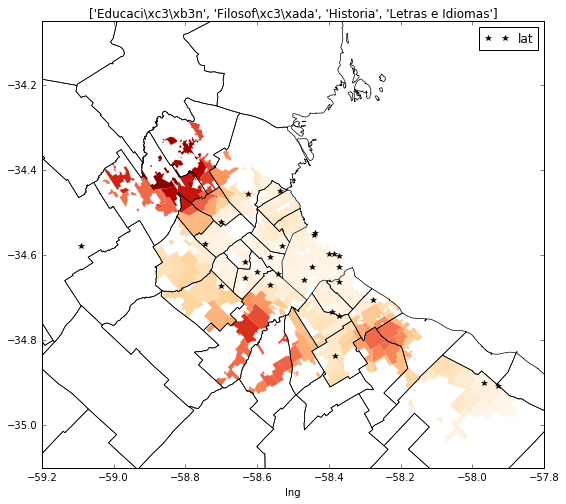

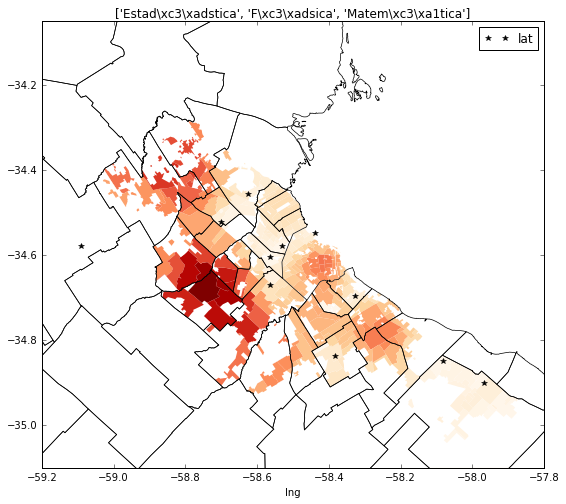

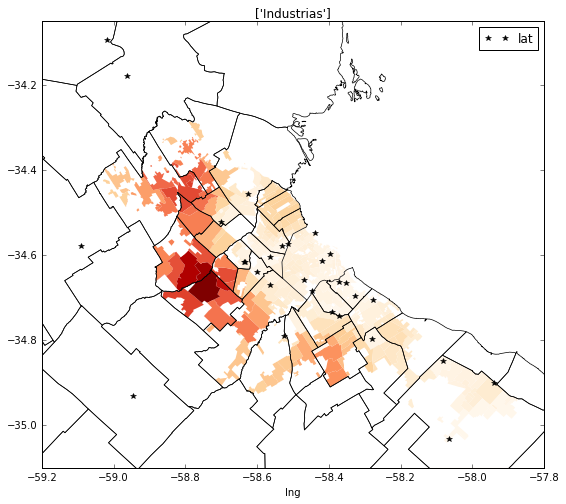

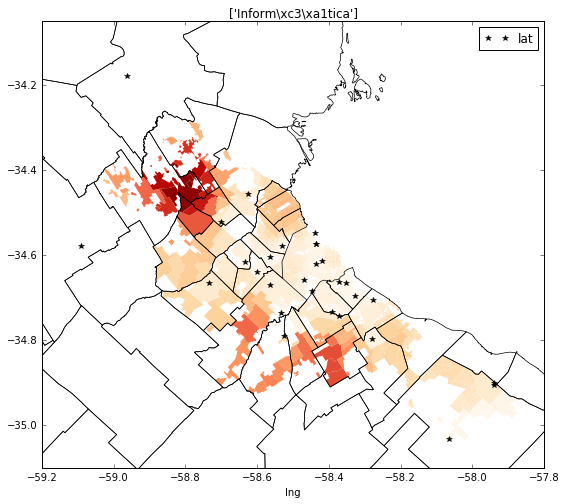

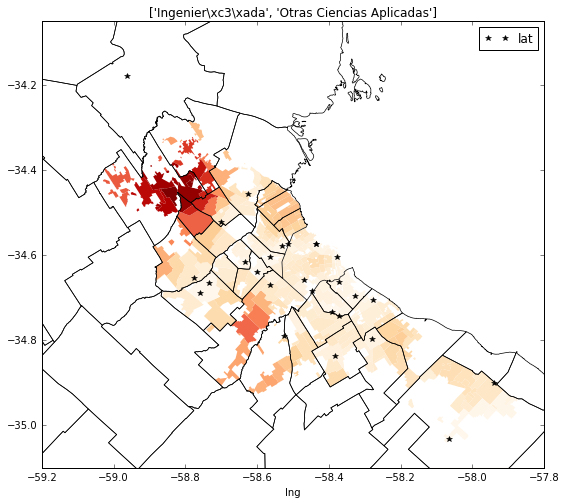

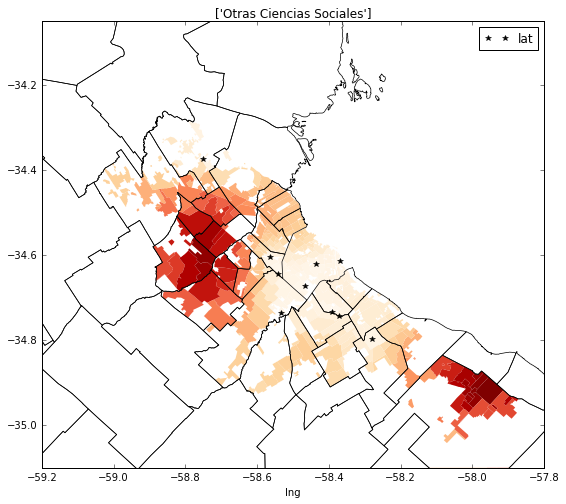

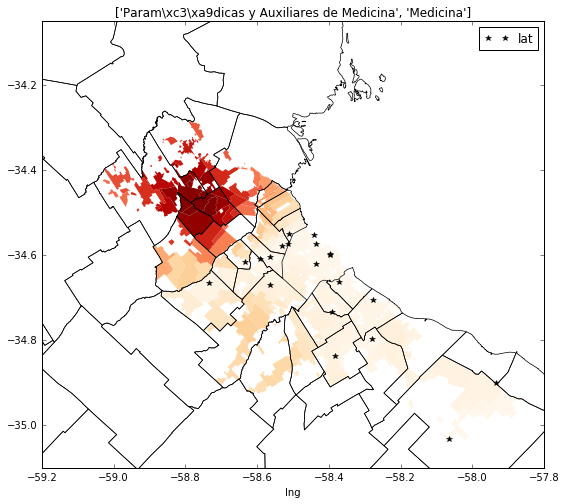

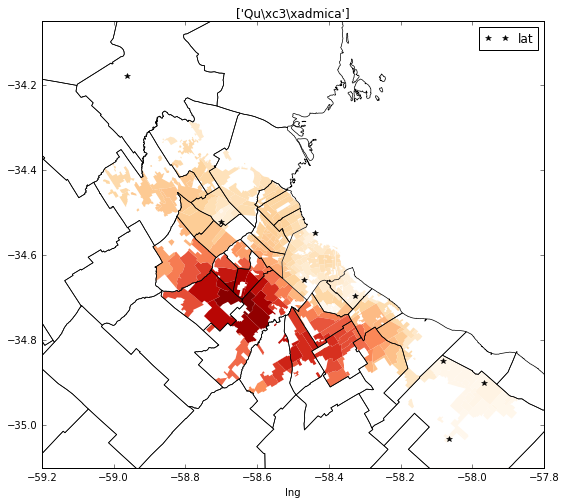

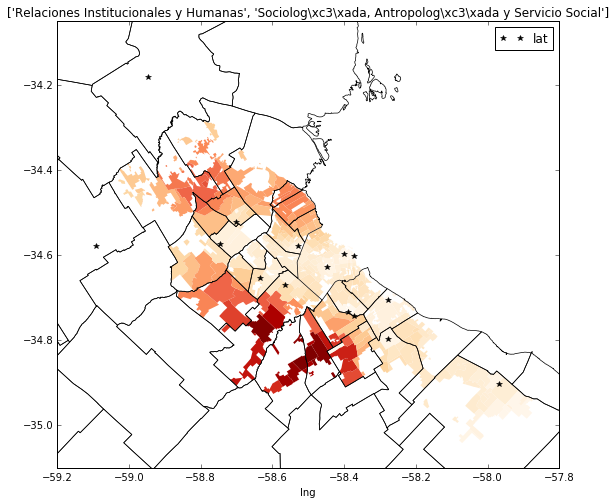

In [11]:
# Compute distance matrix (to universities)

origenes = escuelas_mask[['coords_o']].reset_index()

for temas in [['Arquitectura y Diseño', 'Artes'], ['Biología'], ['Bioquímica y Farmacia'],
              ['Ciencias Agropecuarias'], ['Ciencias de la Información y de la Comunicación'],
              ['Economía y Administración'], ['Educación', 'Filosofía', 'Historia', 'Letras e Idiomas'], 
              ['Estadística', 'Física', 'Matemática'], ['Industrias'], ['Informática'], 
              ['Ingeniería', 'Otras Ciencias Aplicadas'], ['Otras Ciencias Sociales'],
              ['Paramédicas y Auxiliares de Medicina', 'Medicina'], ['Química'], 
              ['Relaciones Institucionales y Humanas', 'Sociología, Antropología y Servicio Social']
             ]:
    
    
    destinos = oferta_estrat_AMBA.loc[oferta_estrat_AMBA.Disciplina.isin(temas)][['Universidad', 'Facultad', 'coords_d']].drop_duplicates()

    origenes['key'] = 0
    destinos['key'] = 0
    distances = pd.merge(origenes, destinos,on='key').set_index(['index','Universidad', 'Facultad']).drop('key', axis = 1)

    # distances
    def f(x):    
        return geopy.distance.vincenty(x['coords_o'], x['coords_d']).km

    distances['distance_km'] = distances.apply(f, axis=1)
    dist_disc = distances.unstack(0)['distance_km'].T

    result_disc = gpd.GeoDataFrame(-(dist_places.T - pd.DataFrame(dist_disc.min(axis = 1)).values.flatten()).T.clip(-np.inf, 0).multiply(escuelas['Matricula est 5to'], axis = 0).sum(), columns = ['dist_saved']).reset_index()
    result_disc = result_disc.merge(localidades[['Localidad', 'geometry']])

    fig, ax = plt.subplots(1, figsize = (9, 8))
    result_disc.plot(column='dist_saved', cmap='OrRd', linewidth = 0, ax = ax)
    facs_lat_lng = oferta_estrat_AMBA.loc[oferta_estrat_AMBA.Disciplina.isin(temas)][['lat', 'lng']].drop_duplicates()
    facs_lat_lng.plot(x = 'lng', y = 'lat', marker = '*', color = 'k',linewidth = 0, ax = ax)
    rural_region.plot(ax = ax, color = 'w', linewidth = 0)
    partidos.plot(ax = ax, facecolor="none", edgecolor='black', lw=0.7)
    ax.set_title(temas)
    ax.set_xlim(-59.2, -57.8)
    ax.set_ylim(-35.1, -34.05)

    plt.show()

### Agrupar sedes en 'Zonas Universitarias'

In [67]:
# sedes_located.nunique()
# sedes_located.to_csv('escuelas_z.csv', index = False)
# compute_zonas(df_loc, th = .3)
sedes_AMBA

,Domicilio,Facultad,Municipio,Pais,Provincia,Universidad,index,lat,lng
0,Av Cabildo 15 - Ciudad Autonoma de Buenos Aire...,Unidad Académica Escuela Superior Técnica,Ciudad de Buenos Aires,ARG,Ciudad Autonoma De Buenos Aires,"Instituto Universitario del Ejército ""Mayor Fr...",0,-34.574760,-58.435630
1,Chacabuco 90 - Ciudad Autonoma de Buenos Aires...,Facultad de Turismo y Hospitalidad,Ciudad de Buenos Aires,ARG,Ciudad Autonoma De Buenos Aires,Universidad Abierta Interamericana,2,-34.609080,-58.376360
3,Lima 717 - Ciudad Autonoma de Buenos Aires - C...,Facultad de Comunicación,Ciudad de Buenos Aires,ARG,Ciudad Autonoma De Buenos Aires,Universidad Argentina de la Empresa,22,-34.617000,-58.381560
4,Lima 717 - Ciudad Autonoma de Buenos Aires - C...,Facultad de Comunicación y Diseño,Ciudad de Buenos Aires,ARG,Ciudad Autonoma De Buenos Aires,Universidad Argentina de la Empresa,22,-34.617000,-58.381560
5,Bartolomé Mitre 1411 - Ciudad Autonoma de Buen...,Facultad de Ciencias Económicas y Empresariales,Ciudad de Buenos Aires,ARG,Ciudad Autonoma De Buenos Aires,Universidad Argentina John F. Kennedy,30,-34.607650,-58.386500
19,25 e/47 y 48 S/N - La Plata - Buenos Aires,Facultad de Ciencias Económicas y Sociales,La Plata,ARG,Buenos Aires,Universidad Católica de La Plata,82,-34.899532,-57.938543
20,11 e/ 51 y 53 972 - La Plata - Buenos Aires,Facultad de Humanidades,La Plata,ARG,Buenos Aires,Universidad Católica de La Plata,86,-34.959930,-57.813430
24,Corrientes 180 - Olivos - Buenos Aires,Departamento Académico Buenos Aires,Vicente López,ARG,Buenos Aires,Universidad Católica de Santiago del Estero,98,-34.507180,-58.476984
29,Zabala 1837 - Ciudad Autonoma de Buenos Aires ...,Facultad de Ciencias Económicas,Ciudad de Buenos Aires,ARG,Ciudad Autonoma De Buenos Aires,Universidad de Belgrano,110,-34.564554,-58.444127
30,Av. Federico Lacroze 1955 - Ciudad Autonoma de...,Facultad de Estudios a Distancia y Educación V...,Ciudad de Buenos Aires,ARG,Ciudad Autonoma De Buenos Aires,Universidad de Belgrano,112,-34.565980,-58.441030


In [51]:
# zonas
sedes_located.to_csv('sedes_loc_clean_z.csv', index = False)


In [48]:
#save
sedes_AMBA.to_csv('./sedes_AMBA_pub_zonas.csv', index = False)
zonas.to_csv('./zonas.csv', index = False)

In [28]:
pd.options.display.max_rows = 999

In [71]:
distances['ranking'] = distances.reset_index().groupby("index")["distance_km"].rank().values
distances.loc[distances.ranking <= 3]

,index_x,coords_d_x,index_y,coords_d_y,distance_km,ranking
0,0,"(-34.57476, -58.43563)",0,"(-34.57476, -58.43563)",0.000000,1.0
1,0,"(-34.57476, -58.43563)",1,"(-34.5721833, -58.4338789)",0.327907,1.0
2,0,"(-34.57476, -58.43563)",2,"(-34.60934, -58.59185)",14.835967,1.0
3,0,"(-34.57476, -58.43563)",47,"(-34.59807, -58.48238)",5.008279,1.0
4,0,"(-34.57476, -58.43563)",48,"(-34.62831, -58.4467)",6.026640,1.0
5,0,"(-34.57476, -58.43563)",49,"(-34.54684, -58.43995)",3.122508,1.0
6,0,"(-34.57476, -58.43563)",50,"(-34.54684, -58.43995)",3.122508,1.0
7,0,"(-34.57476, -58.43563)",51,"(-34.6727, -58.50476)",12.579116,1.0
8,0,"(-34.57476, -58.43563)",52,"(-34.5962099, -58.4775)",4.518679,1.0
9,0,"(-34.57476, -58.43563)",53,"(-34.597903, -58.3974584)",4.342301,1.0


In [71]:
distances_Industrias = distances
distances_Industrias.to_csv('dist_Ind.csv')